<a href="https://colab.research.google.com/github/Eldave93/Seizure-Detection-Tutorials/blob/master/Feature_Extraction_01_Epileptologie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction Tutorial #01
# Epileptologie

by [David Luke Elliott](https://www.lancaster.ac.uk/psychology/about-us/people/david-elliott)
/ [GitHub](https://github.com/Eldave93) 

# Introduction

Key to the performance of any machine learning algorithm is the successful extraction of salient features, which can come from both domain knowledge and computational feature extraction techniques<sup>1</sup>. Therefore the start of any machine learning project is to identify relevant features from knowledge of the data, in this case time-series, or the previous literature on that domain. 

For my own research I extracted a number of features specific to the type of epilpesy I worked on. This tutorial will go over a few of the features that were the easiest to extract. We are going to start this series of tutorials with a small dataset, used by a number of authors, as this will help us get up and running very quickly. Below is a good description of the data by one of the papers who has previously used this dataset:

> *"Five sets (denoted  A–E) each containing  100  single-channel EEG segments of 23.6-sec duration, were composed for the study. These segments were selected and cut out from continuous multichannel EEG recordings after visual inspection  for  artifacts,  e.g.,  due  to  muscle  activity  or  eye  movements. In addition, the segments had to fulfill a stationarity criterion described in detail in Sec. II B. Sets A and B consisted  of  segments  taken  from  surface  EEG  recordings  that were carried out on five healthy volunteers using a standardized  electrode  placement  scheme. Volunteers were relaxed in an awake state with eyes open (A) and eyes closed (B) respectively. Sets C, D, and E originated from our EEG archive of presurgical diagnosis. For the present study EEGs  from  five  patients  were  selected,  all  of  whom  had achieved  complete  seizure  control  after  resection  of  one  of the  hippocampal  formations,  which  was  therefore  correctly diagnosed to be the epileptogenic zone. Segments in set D were recorded from within the epileptogenic zone, and  those  in  set  C  from  the  hippocampal  formation  of  the opposite hemisphere of the brain. While sets C and D contained  only  activity  measured  during  seizure  free  intervals, set  E  only  contained  seizure  activity.  Here  segments  were selected from all recording sites exhibiting ictal activity. All   EEG   signals   were   recorded   with   the   same   128-channel  amplifier  system,  using  an  average  common  reference [omitting electrodes containing pathological activity (C, D, and E) or strong eye movement artifacts (A and B)]. After 12  bit  analog-to-digital  conversion,  the  data  were  written continuously  onto  the  disk  of  a  data  acquisition  computer system  at  a  sampling  rate  of  173.61  Hz.  Band-pass  filter settings were 0.53– 40 Hz (12 dB/oct.)."*<sup>2</sup> 

Below are other published papers that use this the dataset:
- Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907,
- Subasi, A., Kevric, J., & Abdullah Canbaz, M. (2017). Epileptic seizure detection using hybrid machine learning methods. Neural Computing and Applications, 1–9. https://doi.org/10.1007/s00521-017-3003-y

---

1. Raschka, S., & Mirjalili, V. (2017). Python Machine Learning (Second). Packt Publishing.
2. Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

# Environment Set-up

## Install

In [0]:
!pip install matplotlib pandas numpy scipy seaborn mne PyWavelets
!pip install beautifulsoup4 requests wget

    100% |████████████████████████████████| 6.2MB 5.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/39/f9/f5/3e2fdef321f8e1f64061730c8ba2c81ad55c4b1b860b29d2dd
Successfully built mne
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


I have made some code that if these directories do not exist then they will be created and the data needed downloaded and unzipped. If the data already exists it wont wipe it so don't worry about that. Also don't worry about understanding the specifics of what the code is actually doing, the focus of this tutorial is feature extraction not web scraping.

However you can of course manually set this up.  In the Epileptologie Database there are the folders with the data inside - unzip the folders found at http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3. Just make sure the structure goes... 

> ...\Epileptologie Database\F
>
> ...\Epileptologie Database\N
>
> ...\Epileptologie Database\O
>
> ...\Epileptologie Database\S
>
> ...\Epileptologie Database\Z

**NOTES**

- Although refered to as sets A-E in the paper, when downloading them they are given the letters Z, O, N, F, and S respectively.

In [0]:
import sys
import os
from bs4 import BeautifulSoup
import requests
import re
import wget
import zipfile


def find_files(url):
    # get a soup of the directory url
    soup = BeautifulSoup(requests.get(url).text, features="html.parser")

    # make a list of all the links in the url
    hrefs_list = []
    for link in soup.find_all('a'):
        hrefs_list.append(link.get('href'))

    return hrefs_list
    
    
def download_file(download_file_url, file_dir, output=False):
    if output:
        # print it is downloading
        print('Downloading: '+ download_file_url)
    # download the file to the directory
    wget.download(download_file_url, file_dir)
    
    
# needs a directory to download it to
def download_epileptologie(DIR, output=False):
    
    # directory url
    front_url = 'http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3'
    dir_url = 'http://epileptologie-bonn.de/cms'

    hrefs_dir_list = find_files(front_url)
    
    # for each link in the directory
    for link in hrefs_dir_list:
        # download the files outside of participant folders we want
        if re.findall('zip', str(link)):
            # if the file doesnt already exist in the directory
            if not os.path.exists(os.path.join(DIR, link)):
                download_file(dir_url+'/'+str(link), DIR, output)
                zip_file_name = link.split('/')[-1]
                zip_ref = zipfile.ZipFile(os.path.join(DIR, zip_file_name), 'r')
                zip_ref.extractall(os.path.join(DIR, zip_file_name[0]))
                zip_ref.close()
                os.remove(os.path.join(DIR, zip_file_name))

In [0]:
DOWNLOAD_DIR = "Epileptologie Database"

if not os.path.exists(DOWNLOAD_DIR):
  os.makedirs(DOWNLOAD_DIR)
  
download_epileptologie(DOWNLOAD_DIR, output=True)

Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/N.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/F.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/S.zip


This creates a class called color which can be used to change the appearance of things printed in the outputs of each cell. I like using it for nicer outputs.

In [0]:
# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
  
print(color.BOLD+color.UNDERLINE+'Title'+color.END)
print('Hello World')

Title
Hello World


## File List

Lets create a function to list all the files/directories it finds in a location and save them to a list.

**Notes**
- because Google Colab and Juypter output the list order differently I make sure that they are ordered alphabetically

In [0]:
import glob            # for file locations
import pprint          # for pretty printing
import re

pp = pprint.PrettyPrinter()

def file_list(folder_path, output=False):
    # create an empty list
    file_list = []
    # for file name in the folder path...
    for filename in glob.glob(folder_path):
        # ... append it to the list
        file_list.append(filename)
        
    # sort alphabetically
    file_list.sort()
    
    # Output
    if output:
        print(str(len(file_list)) + " files found")
        pp.pprint(file_list)
    
    return file_list

# get folder lists
dir_file_list = file_list(os.path.join(DOWNLOAD_DIR, '*'), output=True)


5 files found
['Epileptologie Database/F',
 'Epileptologie Database/N',
 'Epileptologie Database/O',
 'Epileptologie Database/S',
 'Epileptologie Database/Z']


# Data Load

For the rest of the tutorial (until the very end) we are going to use examples of intercranial EEG activity, recorded from with the 'epileptogenic zone'. The two files we will read in represent seizure and non-seizure brain activity. Lets create an object that represents their file path.

**NOTES**
- If your new to Python you may be wondering why we put a 4 to access the F folder in the list. Python always starts at 0 so although it is the 5th item in the list, you need to put 4 in to access it... you'll get use to doing this eventually and realise why it makes sense.

In [0]:
baseline_file = os.path.join(dir_file_list[0], 'F060.txt')
seizure_file = os.path.join(dir_file_list[3], 'S033.txt')

Lets create a function to read in the data. We will read them in as a Pandas DataFrame. These dataframes hold *"2-dimensional labeled data structure with columns of potentially different types"*<sup>1</sup>

---
1. https://pandas.pydata.org/pandas-docs/stable/dsintro.html

In [0]:
import pandas as pd     # dataframes
import re

def data_load(file_path, output=False):

    # read in the datafile
    data = pd.read_csv(file_path,                 # file in
                       header=None,               # no column names at top of file
                       dtype=float)               # read data as 'floating points' (e.g. 1.0)

    if output:
        print(color.BOLD+color.UNDERLINE+'\n'+re.findall('\w\d+',file_path)[0]+color.END)
        # Output detailed information on the data
        print(color.BOLD+'\nData Information'+color.END)
        data.info()

        # Output first 5 rows and columns
        print(color.BOLD+'\nDataframe Head'+color.END)
        display(data.head())
        
    return data
        

baseline_df = data_load(baseline_file, output=True)
seizure_df = data_load(seizure_file, output=True)


F060

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 1 columns):
0    4097 non-null float64
dtypes: float64(1)
memory usage: 32.1 KB

Dataframe Head


,0
0,162.0
1,164.0
2,164.0
3,154.0
4,139.0



S033

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 1 columns):
0    4097 non-null float64
dtypes: float64(1)
memory usage: 32.1 KB

Dataframe Head


,0
0,216.0
1,182.0
2,146.0
3,128.0
4,116.0


# Mne Data Format

We will be using a package called Mne to visualise aspects of the data. This creates an mne object that can be used to store the data and information about it.

> *"...there are MNE objects. This is of course computer science jargon. What it actually means is that you get a data structure that is more than the channels by time series and the information about channel types and locations, meta-data if you want. Indeed the structures that MNE is using provide so called methods. These are nothing but functions that are configured to take the data and the meta-data of the object as parameters. Sounds complicated, but it’s actually simplifying your life as you will see below. Whether you consider Raw objects that describe continuous data, Epochs objects describing segmented single trial data, or Evoked objects describing averaged data, all have in common that they share certain methods."*<sup>1</sup>

MNE supports different channel types:

    eeg : For EEG channels with data stored in Volts (V)
    meg (mag) : For MEG magnetometers channels stored in Tesla (T)
    meg (grad) : For MEG gradiometers channels stored in Tesla/Meter (T/m)
    ecg : For ECG channels stored in Volts (V)
    seeg : For Stereotactic EEG channels in Volts (V).
    ecog : For Electrocorticography (ECoG) channels in Volts (V).
    fnirs (HBO) : Functional near-infrared spectroscopy oxyhemoglobin data.
    fnirs (HBR) : Functional near-infrared spectroscopy deoxyhemoglobin data.
    emg : For EMG channels stored in Volts (V)
    bio : For biological channels (AU).
    stim : For the stimulus (a.k.a. trigger) channels (AU)
    resp : For the response-trigger channel (AU)
    chpi : For HPI coil channels (T).
    exci : Flux excitation channel used to be a stimulus channel.
    ias : For Internal Active Shielding data (maybe on Triux only).
    syst : System status channel information (on Triux systems only).

    meas_date : list of int

First we'll create an 'info file' which sores information about the EEG. As data is the average of a number of intracranial channels, we will just give them a default location of Cz; This is not the real locations, I just need to do this for the topoplots later. 

---
1. https://mne-tools.github.io/stable/index.html

In [0]:
import mne 
mne.__version__

'0.17.1'

In [0]:
channel_name= ['CZ']
channel_type = ['eeg']
sample_rate = 173.61 # in hz

# The EEG channels use the standard naming strategy.
# Approximate locations will be added for the 10-20 system
montage = 'standard_1020'

# create an mne info file with meta data about the EEG
info = mne.create_info(ch_names=channel_name, sfreq=sample_rate, ch_types=channel_type, montage=montage)

# show the info file
display(info)

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | CZ
    chs : list | 1 items (EEG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 4 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 86.805 Hz
    meas_date : NoneType | unspecified
    nchan : int | 1
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 173.61 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>

I tend to like my columns being channels and rows represeting datapoints but a lot of time series packages have it the other way around. This is why we 'transpose' the data to this other format before loading it into mne. We also first need the data to be in volts rather than in microvolts (which it currently is), so thats why we multiply the data by 1e-6.

In [0]:
def mne_object(data, info, output=False):
    data = data.apply(lambda x: x*1e-6)
    # transpose the data
    data_T = data.transpose()
    # create raw mne object
    raw = mne.io.RawArray(data_T, info)
    
    return raw

baseline_mne = mne_object(baseline_df, info, output=True)
seizure_mne = mne_object(seizure_df, info)

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.


Lets first do a power spectral density (PSD) plot to visualise the distribution of 'power' in the various frequency components that are in the signal. 

As can be seen in the PSD the seizure has much more activity in the lower frequency bands than the baseline

**NOTES**

- To get interactive plots in an offline juypter notebook just use the following at the top of the cell:
  
  `%matplotlib notebook`

- dont worry about the warning...

    *Need more than one channel to make topography for eeg. Disabling interactivity.*
    
  ...this is just because normally in the top right there is normally a topoplot with multipule channels plotted, however as we only have 1 channel it cannot plot this. This may mean the PSD is not too accurate due to the sensor locations not being in their real locations.

Effective window size : 11.797 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


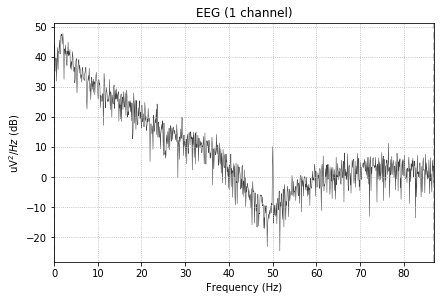

Effective window size : 11.797 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


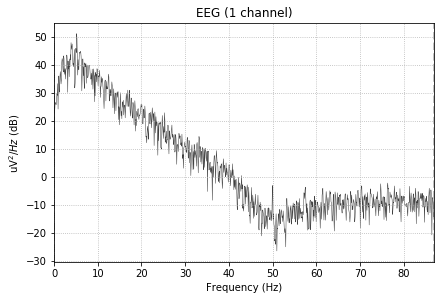

In [0]:
%matplotlib inline

baseline_mne.plot_psd()
seizure_mne.plot_psd();

Now lets actually plot the data and have a look at two examples of 'baseline' and 'seizure' activity

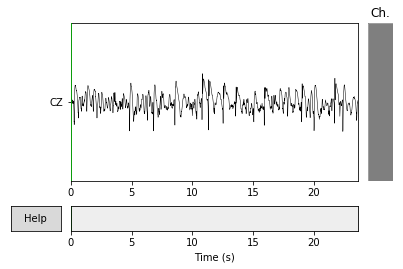

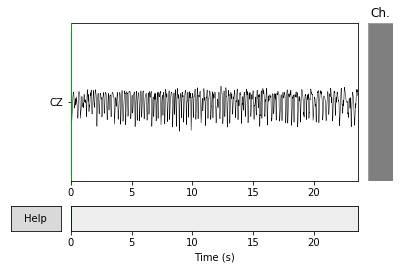

In [0]:
plot_kwargs = {
    'scalings': dict(eeg=20e-4),   # zooms the plot out
    'highpass': 0.53,              # filters out low frequencies
    'lowpass': 40.,                # filters out high frequencies
    'n_channels': 1,               # just plot the one channel
    'duration': 24                 # number of seconds to plot
}

baseline_mne.plot(**plot_kwargs)
seizure_mne.plot(**plot_kwargs);

# Feature Extraction

## Welch

First lets look at how we compute a periodogram using the Welch method.

As EEG contains events that occur at different overlapping frequencies, subspectral components of an EEG signal are often separated and processed discretely, allowing for the decomposition of the signal into frequency bands. To describe a signal in terms of its the frequency components, the data can be transformed by projecting it onto sinusoidal basis functions; with this transformation from the time domain to the frequency domain known as a Fourier transform<sup>1</sup>. Fourier transforms measure oscillation amplitude independent of phase, meaning latency variation can be avoided<sup>2</sup>. Indeed, short-time Fourier transformation’s (STFT), which windows the EEG signal and applies a fast Fourier transformation to each data frame<sup>3</sup>, are often applied to EEG data. Although broadly used, Fourier transforms can loose temporal information from data due to stretching the signal to fit onto sine waves<sup>4</sup>, and the same window size is used to calculate power in different frequencies despite low and high frequencies yielding greater precision with different window sizes<sup>2</sup>. Indeed, the width of the ‘window’ used on the data is important as it can result in poor frequency resolution if too narrow, or poor time localisation that violates the stationarity assumption if too wide<sup>1,5</sup>.

The Welch method is related to a Short-time Fourier transform in that it is a spectral density estimation method that calculates a periodogram for windowed sections of data. Overlapping segments are windowed, as this helps mitagate the loss of information at the edges of the time window, with a discrete Fourier tranform applied to calculate the periodogram. Data is squared and each periodogram averaged to reduce the variance of each power measure.

The Welch method is a common and easy method to apply in both Matlab and Python. In python we can use scipy to get out the power spectral density.

__NOTES__
- The code I wrote will not work with frequencies below 1hz IF we are using 2 second windows because you want at least 2 cycles so for 0.5 you'd need 4 seconds.

---

1. Varsavsky, A., Mareels, I., & Cook, M. (2011). EEG Generation and Measurement. In Epileptic seizures eeg meas. model. detect. predict. (Chap. 2, p. 337). doi:doi:10.1201/b10459-3
2. Luck2014a
3. Kiymik, M. K., Güler, I., Dizibüyük, A., & Akin,M. (2005). Comparison of STFT and wavelet transform methods in determining epileptic seizure activity in EEG signals for real-time application. Comput. Biol. Med. 35(7), 603–616.
4. Luck2014b
5. Rosso, O. A., Martin, M. T., Figliola, A., Keller, K., & Plastino,A. (2006). EEG analysis using wavelet-based information tools. J. Neurosci. Methods, 153(2), 163–182.

In [0]:
from scipy.signal import welch
# specify the lowest frequency your interested in
low = 8

# this is the window size and ensures there are at least 2 cycles 
# of the lowest frequency in the window
nperseg = (2 / low)*sample_rate

# Compute the periodogram (Welch)
freqs, psd = welch(baseline_df, 
                   sample_rate, 
                   nperseg=nperseg,
                   scaling='density', 
                   axis=0)

# put into a df
psd = pd.DataFrame(psd, index = freqs, columns = baseline_df.columns)

print(color.BOLD+'Welch Output'+color.END)
psd.index.name = 'Hz'
psd.columns = ['Power']
display(psd)

Welch Output


,Power
Hz,
0.000000,889.360582
4.037442,5683.980504
8.074884,2434.988822
12.112326,840.116911
16.149767,468.925355
20.187209,200.082613
24.224651,68.433595
28.262093,27.860948
32.299535,19.928694


Now we will just select the frequency range we are interested in from this output and get a mean value

In [0]:
import numpy as np

# specify the higest frequency your interested in
high = 12

# Find closest indices of band in frequency vector
idx_min = np.argmax(np.round(freqs) > low) - 1
idx_max = np.argmax(np.round(freqs) > high)

# select frequencies of interest
psd = psd.iloc[idx_min:idx_max,:]

# get the mean of each channel over all frequencies in the band
psd = psd.mean()

print(color.BOLD+'\nMean Frequency Band'+color.END)
display(psd)


Mean Frequency Band


Power    1637.552866
dtype: float64

Lets now tie both parts into a function

In [0]:
%%time
from scipy.signal import welch
import numpy as np

def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band

    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs, columns = data.columns)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd

baseline_power = bandpower(baseline_df, sample_rate, [8,12], output=True)

Welch Output


,Power
Hz,
0.000000,889.360582
4.037442,5683.980504
8.074884,2434.988822
12.112326,840.116911
16.149767,468.925355
20.187209,200.082613
24.224651,68.433595
28.262093,27.860948
32.299535,19.928694



Mean Frequency Band


Power    1637.552866
dtype: float64

CPU times: user 13.1 ms, sys: 1.3 ms, total: 14.4 ms
Wall time: 16.5 ms


Now we want to get mean values for multipule frequency bands, so we will make a function that wraps the previous function in order to get these values

In [0]:
def power_measures(data, output=False):
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    if output:
        display(welch_df)
    
    return welch_df

print(color.BOLD+color.UNDERLINE+'Baseline Mean Power'+color.END)
baseline_power = power_measures(baseline_df, output=True)

print(color.BOLD+color.UNDERLINE+'Seizure Mean Power'+color.END)
seizure_power = power_measures(seizure_df, output=True)

Baseline Mean Power


power_delta    18864.764238
power_theta     4398.892010
power_alpha     1637.552866
power_beta       461.728763
power_gamma      124.460181
dtype: float64

Seizure Mean Power


power_delta     9811.958106
power_theta    14371.740718
power_alpha     5207.634127
power_beta      1088.598329
power_gamma      265.594331
dtype: float64

## Discrete Wavelet Transform

Another common spectral analysis approach is a wavelet transformation (WT). 

Wavelets can be used to analyse time series with nonstationary power at different frequency bands<sup>3</sup>, express discontinuities caused by recording apparatus<sup>5</sup>, and are useful for identifying and removing artefacts<sup>6,7,8</sup>. 

Several oscillatory kernel-based wavelets are projected onto a signal, dividing the data into different frequency components which are each analysed in respect to their scale<sup>1,2,3</sup>. A 'family' wavelet is a group of functions that is defined by stretching or shrinking a wavelet (dilation) and moving the wavelet to different positions in time (translation)<sup>4</sup>.

Many families exist as can be seen below.
    
---

1. Kiymik, M. K., Güler, I., Dizibüyük, A., & Akin, M. (2005). Comparison of STFT and wavelet transform methods in determining epileptic seizure activity in EEG signals for real-time application. Computers in Biology and Medicine, 35(7), 603–616. https://doi.org/10.1016/j.compbiomed.2004.05.001
2. Sakkalis, V., Cassar, T., Zervakis, M., Camilleri, K. P., Fabri, S. G., Bigan, C., … Micheloyannis, S. (2008). Parametric and nonparametric EEG analysis for the evaluation of EEG activity in young children with controlled epilepsy. Computational Intelligence and Neuroscience, 2008. https://doi.org/10.1155/2008/462593
3. Sakkalis, V., Zervakis, M., & Micheloyannis, S. (2006). Significant EEG features involved in mathematical reasoning: Evidence from wavelet analysis. Brain Topography, 19(1–2), 53–60. https://doi.org/10.1007/s10548-006-0012-z
4. Rosso, O. A., Martin, M. T., Figliola, A., Keller, K., & Plastino, A. (2006). EEG analysis using wavelet-based information tools. Journal of Neuroscience Methods, 153(2), 163–182. https://doi.org/10.1016/j.jneumeth.2005.10.009
5. Akin, M., & Kiymik, M. K. (2000). Application of periodogram and AR spectral analysis to EEG signals. Journal of Medical Systems, 24(4), 247–256. https://doi.org/10.1023/A:1005553931564
6. Khatun, S., Mahajan, R., & Morshed, B. I. (2016). Comparative Study of Wavelet-Based Unsupervised Ocular Artifact Removal Techniques for Single-Channel EEG Data. IEEE Journal of Translational Engineering in Health and Medicine, 4(December 2015). https://doi.org/10.1109/JTEHM.2016.2544298
7. Mammone, N., & Morabito, F. C. (2014). Enhanced automatic wavelet independent component analysis for electroencephalographic artifact removal. Entropy, 16(12), 6553–6572. https://doi.org/10.3390/e16126553
8. Olund, T., Duun-Henriksen, J., Kjaer, T. W., & Sorensen, H. B. D. (2014). Automatic detection and classification of artifacts in single-channel EEG. 2014 36th Annual International Conference of the IEEE Engineering in Medicine and Biology Society, EMBC 2014, 922–925. https://doi.org/10.1109/EMBC.2014.6943742

In [0]:
from pywt import families

families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

Lets start by looking at the simplest, the Haar wavelet

In [0]:
from pywt import Wavelet

wavelet = Wavelet('Haar')
print(wavelet)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


As can be seen below, this appears as a square wave. Essentally a Haar transform just cross-multiplies a function against this wave with various shifts and stretches in time.

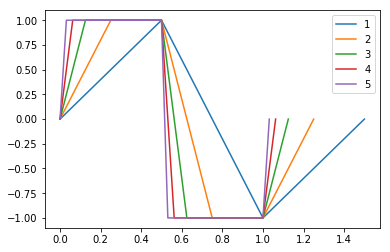

In [0]:
import matplotlib.pyplot as plt

labels = []
for level in range(1,6):
    [phi, psi, x] = wavelet.wavefun(level=level)
    plt.plot(x, psi)
    labels.append(level)
plt.legend(labels)

The Daubechies 4 wavelet (db4) is the most commonly used wavelet for EEG and epilepsy seizure detection as it is smooths the frequency filtering enough to characterise the EEG, but is also computationally efficient<sup>1,2,3</sup>.

---
1. Kjær, T. W., Sorensen, H. B. D., Groenborg, S., Pedersen, C. R., & Duun-Henriksen, J. (2017). Detection of Paroxysms in Long-Term, Single Channel EEG-Monitoring of Patients with Typical Absence Seizure. IEEE Journal of Translational Engineering in Health and Medicine, 5(September 2016). https://doi.org/10.1109/JTEHM.2017.2649491
2. Subasi, A. (2007). EEG signal classification using wavelet feature extraction and a mixture of expert model. Expert Systems with Applications, 32(4), 1084–1093. https://doi.org/10.1016/j.eswa.2006.02.005
3. Adeli, H., Zhou, Z., & Dadmehr, N. (2003). Analysis of EEG records in an epileptic patient using wavelet transform. Journal of Neuroscience Methods, 123(1), 69–87. https://doi.org/10.1016/S0165-0270(02)00340-0

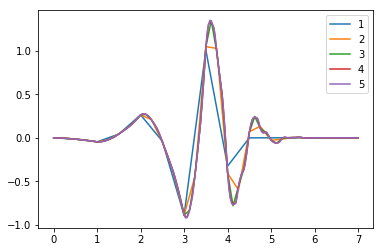

In [0]:
labels = []
for level in range(1,6):
    [phi, psi, x] = Wavelet('db4').wavefun(level=level)
    plt.plot(x, psi)
    labels.append(level)
plt.legend(labels)

Now lets get the list of arrays out, each represeting the coefficients at a specific level. Now I am using a 'decimated' transform here so the length of data going in is different to the length out.

__Decimation at 173.61hz with a Daubechies 4 wavelet__

- D1: 43.40 - 86.805 (Gamma)

- D2: 21.7 - 43.40 (Beta/Gamma)

- D3: 10.85 - 21.7 (Beta)

- D4: 5.43 - 10.85 (Alpha)

- D5: 2.71 - 5.43 (Theta)

- D6: 1.36 - 2.71 (Delta)

- A6: >1.36 (Delta/DC)

In [0]:
from pywt import wavedec

# number of levels we are interested in
level = 6

# transpose the data because its a time-series package
data_t = baseline_df.transpose()

# get the wavelet coefficients at each level in a list
coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)

print(type(coeffs_list))
print(color.BOLD+color.UNDERLINE+'\nExample first array'+color.END)
coeffs_list[0]

<class 'list'>

Example first array


array([[ 1181.70402535,  1222.31934684,  1186.58114564,  1119.30615032,
         1604.0324783 ,    25.89019047,  1780.72838765,  -973.90578049,
         1220.89183062,  1293.42816916,   969.47947677,  -157.9270515 ,
         -563.78624385,  -932.26288111,    -9.97373656, -1153.16884245,
         -388.46627896,  -978.83447438,   825.79767601, -2068.52191341,
         -902.76616695,  -907.06309716,    33.94486868,  -323.56923264,
        -1303.9367751 ,   341.99794327, -1239.81391063, -1374.40588055,
         2176.67574815,  -873.9977607 ,   136.07105931,  -576.83053461,
        -1754.71926172, -1129.91038679,  2414.20323465,  2157.9675786 ,
         2817.67685717,  -206.68406909,   418.16443435,  2386.0601948 ,
          686.29657472, -1793.06453077,  2091.92878426, -1253.63309753,
         -921.75978608, -2782.32520904,    44.8599721 , -2744.14365319,
          685.7713572 ,   444.34853778,  -540.8882925 ,  -131.68367604,
           15.37213474,  1753.78765896, -1375.40957813,  1227.31

Lets make a list of the names of the coefficients (the name of each array in the list).

In [0]:
# make a list of the component names (later column rows)
nums = list(range(1,level+1))
names=[]
for num in nums:
    names.append('D' + str(num))
names.append('A' + str(nums[-1]))

# reverse the names so it counts down
names = names[::-1] 

names

['A6', 'D6', 'D5', 'D4', 'D3', 'D2', 'D1']

Now lets turn the arrays into dataframes and use these names as the header.

In [0]:
# make an empty dataframe
wavelets = pd.DataFrame()

# for each array in the list of arrays
for i, array in enumerate(coeffs_list):
    # turn into a dataframe and transpose
    level_df = pd.DataFrame(array).T
    # name the column the appropriate level name
    level_df.columns = [names[i]]
    # if the wavelets df is empty...
    if wavelets.empty:
        # ... make the first level df the wavelets df
        wavelets = level_df
    # ..otherwise...
    else:
        # ... add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1)

wavelets.head()

,A6,D6,D5,D4,D3,D2,D1
0,1181.704025,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,1222.319347,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,1186.581146,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,1119.306150,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,1604.032478,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


You may be wondering what the difference is between the A and the D's. Well the A stands for the 'approximation coefficient' and the D 'detail coefficient'. The detail coefficients come from high-pass filters applied to the data and approximation coefficients from the low-pass. A series of these filters are applied, each time the output of the low-pass filter is subsampled by 2 and further processed by passing it again through a new low-pass filter and a high-pass filter with half the cut-off frequency of the previous one. 

A discrete transform reduces the output so, although there are multipule approximation coefficient's during calculation, we only get the last one which for our purpose contains information about the rest of the frequencies below a range.

In [0]:
# remove the AN levels
regex = re.compile('D')
bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
decom_wavelets = wavelets.drop(bad_items, axis=1)

decom_wavelets.head()

,D6,D5,D4,D3,D2,D1
0,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


Lets take everything we have done so far and now put it in a function

In [0]:
%%time

def wavelet_decompose(data, output=False):
    
    # decompose data into coefficients
    level = 6
    
    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))
    
    # reverse the names so it counts down
    names = names[::-1] 
    
    # make an empy dataframe
    wavelets = pd.DataFrame()
    
    # for each array in the list of arrays
    for i, array in enumerate(coeffs_list):
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array).T
        # name the column the appropriate level name
        level_df.columns = [names[i]]
        # if the wavelets df is empty...
        if wavelets.empty:
            # ... make the first level df the wavelets df
            wavelets = level_df
        # ..otherwise...
        else:
            # ... add the next levels df to another column
            wavelets = pd.concat([wavelets,level_df], axis=1)
    
    # remove the AN levels
    regex = re.compile('D')
    bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
    decom_wavelets = wavelets.drop(bad_items, axis=1)
    
    if output:
        display(decom_wavelets.head())
    
    return decom_wavelets

print(color.BOLD+color.UNDERLINE+'Baseline Wavelets'+color.END)
baseline_wavelets = wavelet_decompose(baseline_df, output=True)
print(color.BOLD+color.UNDERLINE+'Seizure Wavelets'+color.END)
seizure_wavelets = wavelet_decompose(seizure_df, output=True)

Baseline Wavelets


,D6,D5,D4,D3,D2,D1
0,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


Seizure Wavelets


,D6,D5,D4,D3,D2,D1
0,-1.453415,3.509509,1.371142,-39.013247,16.636231,-2.599961
1,43.379262,12.122656,6.139127,-125.503920,47.450001,-6.130291
2,812.623570,341.595063,-82.442431,41.496346,-37.573145,4.643268
3,895.330335,-1050.533142,-955.747389,383.529468,23.351784,1.448993
4,305.768800,-937.803247,765.936772,-54.180950,87.072116,3.218840


CPU times: user 38.5 ms, sys: 4.29 ms, total: 42.7 ms
Wall time: 43.6 ms


## Wavelet Features
There are 5 features that come from the wavelet transform that I will focus on in this tutorial:
- Kjær et al. (2016)<sup>4</sup>
    - Log-Sum of the wavelet transform
- Subasi (2007)<sup>6</sup>
    - Mean of the absolute values of the coefficients in each sub-band
    - Average power of the wavelet coefficients in each sub-band
    - Standard deviation of the coefficients in each sub-band
    - Ratio of the absolute mean values of adjacent sub-bands

### Log Sum

The log sum of the wavelet coefficients is a common method<sup>1,2,3,4</sup> in the seizure detection literature to create a feature for the machine learning method. The detail coefficents without futher processing can eb sensitive to noise, therefore Shoeb et. al. suggested applying the log-sum energy of the subband coefficients as features. 


The log transform is a power transform which change the distribution of a variable so that the variance is no longer dependent on the mean. The log function maps a range of numbers to a smaller range by compressing large numbers and expanding the range of small numbers. For example log10(x) maps the range of [1, 10] to [0, 1], [10, 100] to [1, 2]. The log is particularly useful where there is a heavy-tailed distribution because it compresses the long tail at the high end of the distribution and extends the low tail<sup>5</sup>. 

**NOTES**
- to make sure there are no negative numbers before the log transform we minus the smallest minus number from all data +1 so that the smallest number is 0 after the trasform.

---

1. Shoeb, A., Edwards, H., Connolly, J., Bourgeois, B., Ted Treves, S., & Guttag, J. (2004). Patient-specific seizure onset detection. Epilepsy & Behavior, 5(4), 483–498. https://doi.org/10.1016/j.yebeh.2004.05.005
2. Petersen, E. B., Duun-Henriksen, J., Mazzaretto, A., Kjar, T. W., Thomsen, C. E., & Sorensen, H. B. D. (2011). Generic single-channel detection of absence seizures. Proceedings of the Annual International Conference of the IEEE Engineering in Medicine and Biology Society, EMBS, 4820–4823. https://doi.org/10.1109/IEMBS.2011.6091194
3. J. Duun-Henriksen, R. E. Madsen, L. S. Remvig, C. E. Thomsen, H. B. D. Sorensen, and T. W. Kjaer, ‘‘Automatic detection of childhood absence epilepsy seizures: Toward a monitoring device,’’ Pediatric Neurol., vol. 46, no. 5, pp. 287–292, 2012.
4. Kjær, T. W., Sorensen, H. B. D., Groenborg, S., Pedersen, C. R., & Duun-Henriksen, J. (2017). Detection of Paroxysms in Long-Term, Single Channel EEG-Monitoring of Patients with Typical Absence Seizure. IEEE Journal of Translational Engineering in Health and Medicine, 5(September 2016). https://doi.org/10.1109/JTEHM.2017.2649491
5. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".
6. Subasi, A., Kevric, J., & Abdullah Canbaz, M. (2017). Epileptic seizure detection using hybrid machine learning methods. Neural Computing and Applications, 1–9. https://doi.org/10.1007/s00521-017-3003-y

In [0]:
def log_sum(data, output=False):
    absolute_sums = data.sum()
    # find the smallest value for each data column (channel)...
    min_val = absolute_sums.min()
    # ...and subtract it from all the data in the column and add one
    absolute_sums_minus = absolute_sums.subtract(min_val).add(1)
    # find the log of each elecment (datapoint)
    absolute_sums_log = absolute_sums_minus.apply(np.log)
    absolute_sums_log.index += '_LSWT'
    
    if output:
        display(absolute_sums_log)
    
    return absolute_sums_log
    
print(color.BOLD+color.UNDERLINE+'Baseline Log Sum Wavelets'+color.END)
baseline_LSWT = log_sum(baseline_wavelets, output=True)
print(color.BOLD+color.UNDERLINE+'Seizure Log Sum Wavelets'+color.END)
seizure_LSWT = log_sum(seizure_wavelets, output=True)

Baseline Log Sum Wavelets


D6_LSWT    8.602904
D5_LSWT    9.469257
D4_LSWT    0.000000
D3_LSWT    9.170792
D2_LSWT    9.041026
D1_LSWT    9.067926
dtype: float64

Seizure Log Sum Wavelets


D6_LSWT    9.917802
D5_LSWT    0.000000
D4_LSWT    9.864632
D3_LSWT    9.019552
D2_LSWT    8.800622
D1_LSWT    8.758482
dtype: float64

### Subasi Features

The rest of the features here are taken from Subasi<sup>1</sup>, afterall this is the same dataset they used. Most of them are self-explanatory.

---
1. Subasi, A., Kevric, J., & Abdullah Canbaz, M. (2017). Epileptic seizure detection using hybrid machine learning methods. Neural Computing and Applications, 1–9. https://doi.org/10.1007/s00521-017-3003-y

#### Average power of the wavelet coefficients in each sub-band

In [0]:
def ave(data, output=False):
    # get the mean
    mean_data = data.mean()
    
    mean_data.index += '_mean'
    
    if output:
        display(mean_data)
    
    return mean_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Mean Wavelets'+color.END)
baseline_mean = ave(baseline_wavelets, output=True)
print(color.BOLD+color.UNDERLINE+'Seizure Mean Wavelets'+color.END)
seizure_mean = ave(seizure_wavelets, output=True)

Baseline Mean Wavelets


D6_mean   -37.834936
D5_mean    36.263856
D4_mean   -30.896570
D3_mean     2.927276
D2_mean     0.336768
D1_mean     0.281050
dtype: float64

Seizure Mean Wavelets


D6_mean    197.020829
D5_mean    -48.476820
D4_mean     48.629387
D3_mean      3.409618
D2_mean      0.137491
D1_mean     -0.064546
dtype: float64

#### Mean of the absolute values of the coefficients in each sub-band

In [0]:
def mean_abs(data, output=False):
    # get the mean of the absolute values
    mean_abs_data = data.abs().mean()
    
    mean_abs_data.index += '_mean_abs'
    
    if output:
        display(mean_abs_data)
    
    return mean_abs_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Mean Absolute Wavelets'+color.END)
baseline_mean_abs = mean_abs(baseline_wavelets, output=True)
print(color.BOLD+color.UNDERLINE+'Seizure Mean Absolute Wavelets'+color.END)
seizure_mean_abs = mean_abs(seizure_wavelets, output=True)

Baseline Mean Absolute Wavelets


D6_mean_abs    1104.206464
D5_mean_abs     663.024968
D4_mean_abs     285.744116
D3_mean_abs     108.987663
D2_mean_abs      32.573515
D1_mean_abs       7.176143
dtype: float64

Seizure Mean Absolute Wavelets


D6_mean_abs     699.840962
D5_mean_abs    1139.976482
D4_mean_abs     642.228332
D3_mean_abs     205.319757
D2_mean_abs      38.483226
D1_mean_abs       5.566980
dtype: float64

#### Standard deviation of the coefficients in each sub-band

In [0]:
def coeff_std(data, output=False):
    # get the standard deviation of the coeficients
    std_data = data.std()
    
    std_data.index += '_std'
    
    if output:
        display(std_data)
    
    return std_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Standard Deviation Wavelets'+color.END)
baseline_std = coeff_std(baseline_wavelets, output=True)
print(color.BOLD+color.UNDERLINE+'Seizure Standard Deviation Wavelets'+color.END)
seizure_std = coeff_std(seizure_wavelets, output=True)

Baseline Standard Deviation Wavelets


D6_std    1383.046728
D5_std     824.861085
D4_std     403.580263
D3_std     202.771574
D2_std      60.314355
D1_std      17.320777
dtype: float64

Seizure Standard Deviation Wavelets


D6_std     841.682451
D5_std    1345.577955
D4_std     782.524543
D3_std     272.581103
D2_std      55.802148
D1_std       9.202684
dtype: float64

#### Ratio of the absolute mean values of adjacent sub-bands

This one is a bit more difficult to code, purely because you have to account for the first and last band will not have a coefficent either side of them. Thats the only reason there is an if, elif and else in there.

In [0]:
def ratio(data, output=False):
    # get the mean of the absolute values
    data = data.abs().mean()
    # get a list of the index
    decimation_levels = list(data.index)

    ratio_data=pd.Series(index=data.index)
    for level_no in range(0, len(decimation_levels)):
        # for the first decimation
        if level_no == 0:
            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/data.loc[decimation_levels[level_no+1]]

        #for the last decimation
        elif level_no == len(decimation_levels)-1:
            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/data.loc[decimation_levels[level_no-1]]
        else:
            before = data.loc[decimation_levels[level_no-1]]
            after = data.loc[decimation_levels[level_no+1]]
            mean_data = (before+after)/2

            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/mean_data

    ratio_data.index += '_Ratio'
    
    if output:
        display(ratio_data)
    
    return ratio_data


print(color.BOLD+color.UNDERLINE+'Baseline Ratio Wavelets'+color.END)
baseline_ratio = ratio(baseline_wavelets, output=True)
print(color.BOLD+color.UNDERLINE+'Seizure Ratio Wavelets'+color.END)
seizure_ratio = ratio(seizure_wavelets, output=True)

Baseline Ratio Wavelets


D6_Ratio    1.665407
D5_Ratio    0.954027
D4_Ratio    0.740258
D3_Ratio    0.684773
D2_Ratio    0.560820
D1_Ratio    0.220306
dtype: float64

Seizure Ratio Wavelets


D6_Ratio    0.613908
D5_Ratio    1.698834
D4_Ratio    0.954776
D3_Ratio    0.603250
D2_Ratio    0.364966
D1_Ratio    0.144660
dtype: float64

# Assemble Feature DataFrame

We're creating this combine function to take all the data from the different feature extraction methods and combine them into one dataframe.

In [0]:
def combine(power_data, LSWT_data, mean_data, mean_abs_data, std_data, ratio_data, file_name, output = False):
    # combine each feature file into one long dataframe
    combined_series = pd.concat([power_data, LSWT_data, mean_data, mean_abs_data, std_data, ratio_data], axis = 'index')
    # turn this series into a dataframe
    combined_df = pd.DataFrame(combined_series)
    # transpose so the features become separate columns
    combined_df = combined_df.T
    
    # get the file identifier from the file (e.g. F001)
    file_identifier = re.findall('\w\d+', file_name)[0]
    # add this identifier to a column
    combined_df['file_id'] = file_identifier
    
    # if the file identifier has an S in...
    if re.findall('S', file_identifier):
        # make a class column with 'seizure' in
        combined_df['class'] = 'seizure'
    # ...otherwise...
    else:
        # .. make a class column with 'Baseline' in
        combined_df['class'] = 'baseline'
        
    
    # if the file identifier has a Z or O in...
    if re.findall('Z|O', file_identifier):
        # make a location column with 'surface' in
        combined_df['location'] = 'surface'
    # if the file identifier has an N in...
    elif re.findall('N', file_identifier):
        # make a location column with 'intracranial hippocampus' in
        combined_df['location'] = 'intracranial hippocampus'
    # if the file identifier has an S or F in...
    elif re.findall('F|S', file_identifier):
        # make a location column with 'intracranial epileptogenic zone' in
        combined_df['location'] = 'intracranial epileptogenic zone'
        
    # name the index
    combined_df.columns.name = 'feature'
    
    # add the file_id and class to the index
    combined_df = combined_df.set_index(['file_id', 'class', 'location'])
    # reorder the index so class is first, then file_id, then feature
    combined_df = combined_df.reorder_levels(['class', 'location', 'file_id'], axis='index')
    
    if output:
        display(combined_df)
        
    return combined_df
    
baseline_combined_df = combine(baseline_power, baseline_LSWT, baseline_mean, baseline_mean_abs, baseline_std, baseline_ratio, baseline_file, output = True)

,,feature,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,...,D4_std,D3_std,D2_std,D1_std,D6_Ratio,D5_Ratio,D4_Ratio,D3_Ratio,D2_Ratio,D1_Ratio
class,location,file_id,,,,,,,,,,,,,,,,,,,,,
baseline,intracranial epileptogenic zone,F060,18864.764238,4398.89201,1637.552866,461.728763,124.460181,8.602904,9.469257,0.0,9.170792,9.041026,...,403.580263,202.771574,60.314355,17.320777,1.665407,0.954027,0.740258,0.684773,0.56082,0.220306


Now below is the code to take all those functions we have worked on so far and use them on all the data, and then combining the outputs into one big dataframe.

**NOTES**
- for me it takes 19.8 s
- we use JSON rather than pickle (which can compress it down more) to save because JSON does not introduce a security hole and allows the data to be used by programs in different languages.

In [0]:
%%time

# make an empty dataframe
feature_df = pd.DataFrame()

for folder in dir_file_list:
    
    folder_files_list = file_list(os.path.join(folder, '*'))
    
    for file in folder_files_list:
        df = data_load(file)
        power_data = power_measures(df)
        wavelets = wavelet_decompose(df)
        LSWT_data = log_sum(wavelets)
        mean_data = ave(wavelets)
        mean_abs_data = mean_abs(wavelets)
        std_data = coeff_std(wavelets)
        ratio_data = ratio(wavelets)
        file_combined = combine(power_data, LSWT_data, mean_data, 
                                mean_abs_data, std_data, ratio_data, file)
        
        if feature_df.empty:
            feature_df = file_combined
        else:
            feature_df = pd.concat([feature_df, file_combined], axis='index')

# display the dataframe
display(feature_df)

# reset the index into columns (for easy saving)
feature_df_save = feature_df.reset_index()

# save the dataframe to disk for later use
feature_df_save.to_json('feature_df.json.gzip', 
                        orient='index', 
                        compression = 'gzip') 

feature                                            power_delta  power_theta  \
class    location                        file_id                              
baseline intracranial epileptogenic zone F001       125.389091    38.175072   
                                         F002      3797.194021   492.166476   
                                         F003       787.823018   208.119170   
                                         F004       240.974656   105.055098   
                                         F005      1154.608671   462.277208   
                                         F006        55.212987    47.232717   
                                         F007       231.715868    93.458704   
                                         F008      2125.141636   433.080685   
                                         F009     34941.395206  9748.021407   
                                         F010      3805.190513   649.989655   
                                         F011       508.088808   232.580771   
                                         F012       306.643771   153.548523   
                                         F013        96.545134    46.997647   
                                         F014       114.828816    70.362820   
                                         F015        93.022425    72.843591   
                                         F016       486.484648   181.246567   
                                         F017       150.199714   134.021691   
                                         F018       369.102379   352.525485   
                                         F019       122.914377   101.440335   
                                         F020       273.673204    65.502880   
                                         F021      2597.801359   924.098951   
                                         F022       801.920702   173.862192   
                                         F023       343.271507   399.164835   
                                         F024       860.788882   406.013447   
                                         F025      1760.663891   543.593999   
                                         F026        63.929050    27.040120   
                                         F027       849.334308   165.148690   
                                         F028       233.327918   136.307906   
                                         F029      2195.051399   264.603032   
                                         F030      3552.134955   825.325116   
...                                                        ...          ...   
         surface                         Z071       307.195869    82.784157   
                                         Z072       177.739219    86.962126   
                                         Z073        52.240229    28.901155   
                                         Z074       165.870630    78.038941   
                                         Z075       193.010085    76.589511   
                                         Z076       108.728672    38.467508   
                                         Z077       247.641745   109.854192   
                                         Z078        95.060475    73.294925   
                                         Z079        99.054301    56.481473   
                                         Z080        38.706486    23.181384   
                                         Z081       120.944379    80.697776   
                                         Z082       113.521945   106.779899   
                                         Z083        65.688498    37.629776   
                                         Z084       141.960739    44.851016   
                                         Z085       176.631501    80.017708   
                                         Z086       167.080463    66.814449   
                                         Z087        78.746105    63.769894   
                                         Z088     

CPU times: user 13.2 s, sys: 44.2 ms, total: 13.2 s
Wall time: 13.2 s


## Save
We have saved the data onto the disk in colab but it will be deleted when you (re-)connect to an instance. Therefore you may want to connect a google drive (as seen below) or us the left tab to save the data (locate the file in Files, then right click the file and download).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Below may be different for you depending on how you set up your google drive. I just made a folder in there called 'Data' which I save this sort of data in. If you do the same then it will work

In [0]:
# save the dataframe to disk for later use
feature_df_save.to_json('/content/gdrive/My Drive/Data/feature_df.json.gzip', 
                        orient='index', 
                        compression = 'gzip') 

# Exercises

Below are a few suggested exercises that may help improve your skills.

**TODO**
- Make some exercises...

# License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.